In [1]:
%cd game-behavior-analytics/data_analysis_notebook/

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Cell 1: Setup and Data Preparation

In [2]:
# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

In [3]:
# ============================================================================
# DATA PREPARATION
# ============================================================================

# Load data
df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    if cheating_rate == 0:
        return 0  # Non-cheater
    elif cheating_rate == 1:
        return 2  # Full cheater
    else:
        return 1  # Partial cheater

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2
df["performance"] = df["performance_score_including_cheated_words"]


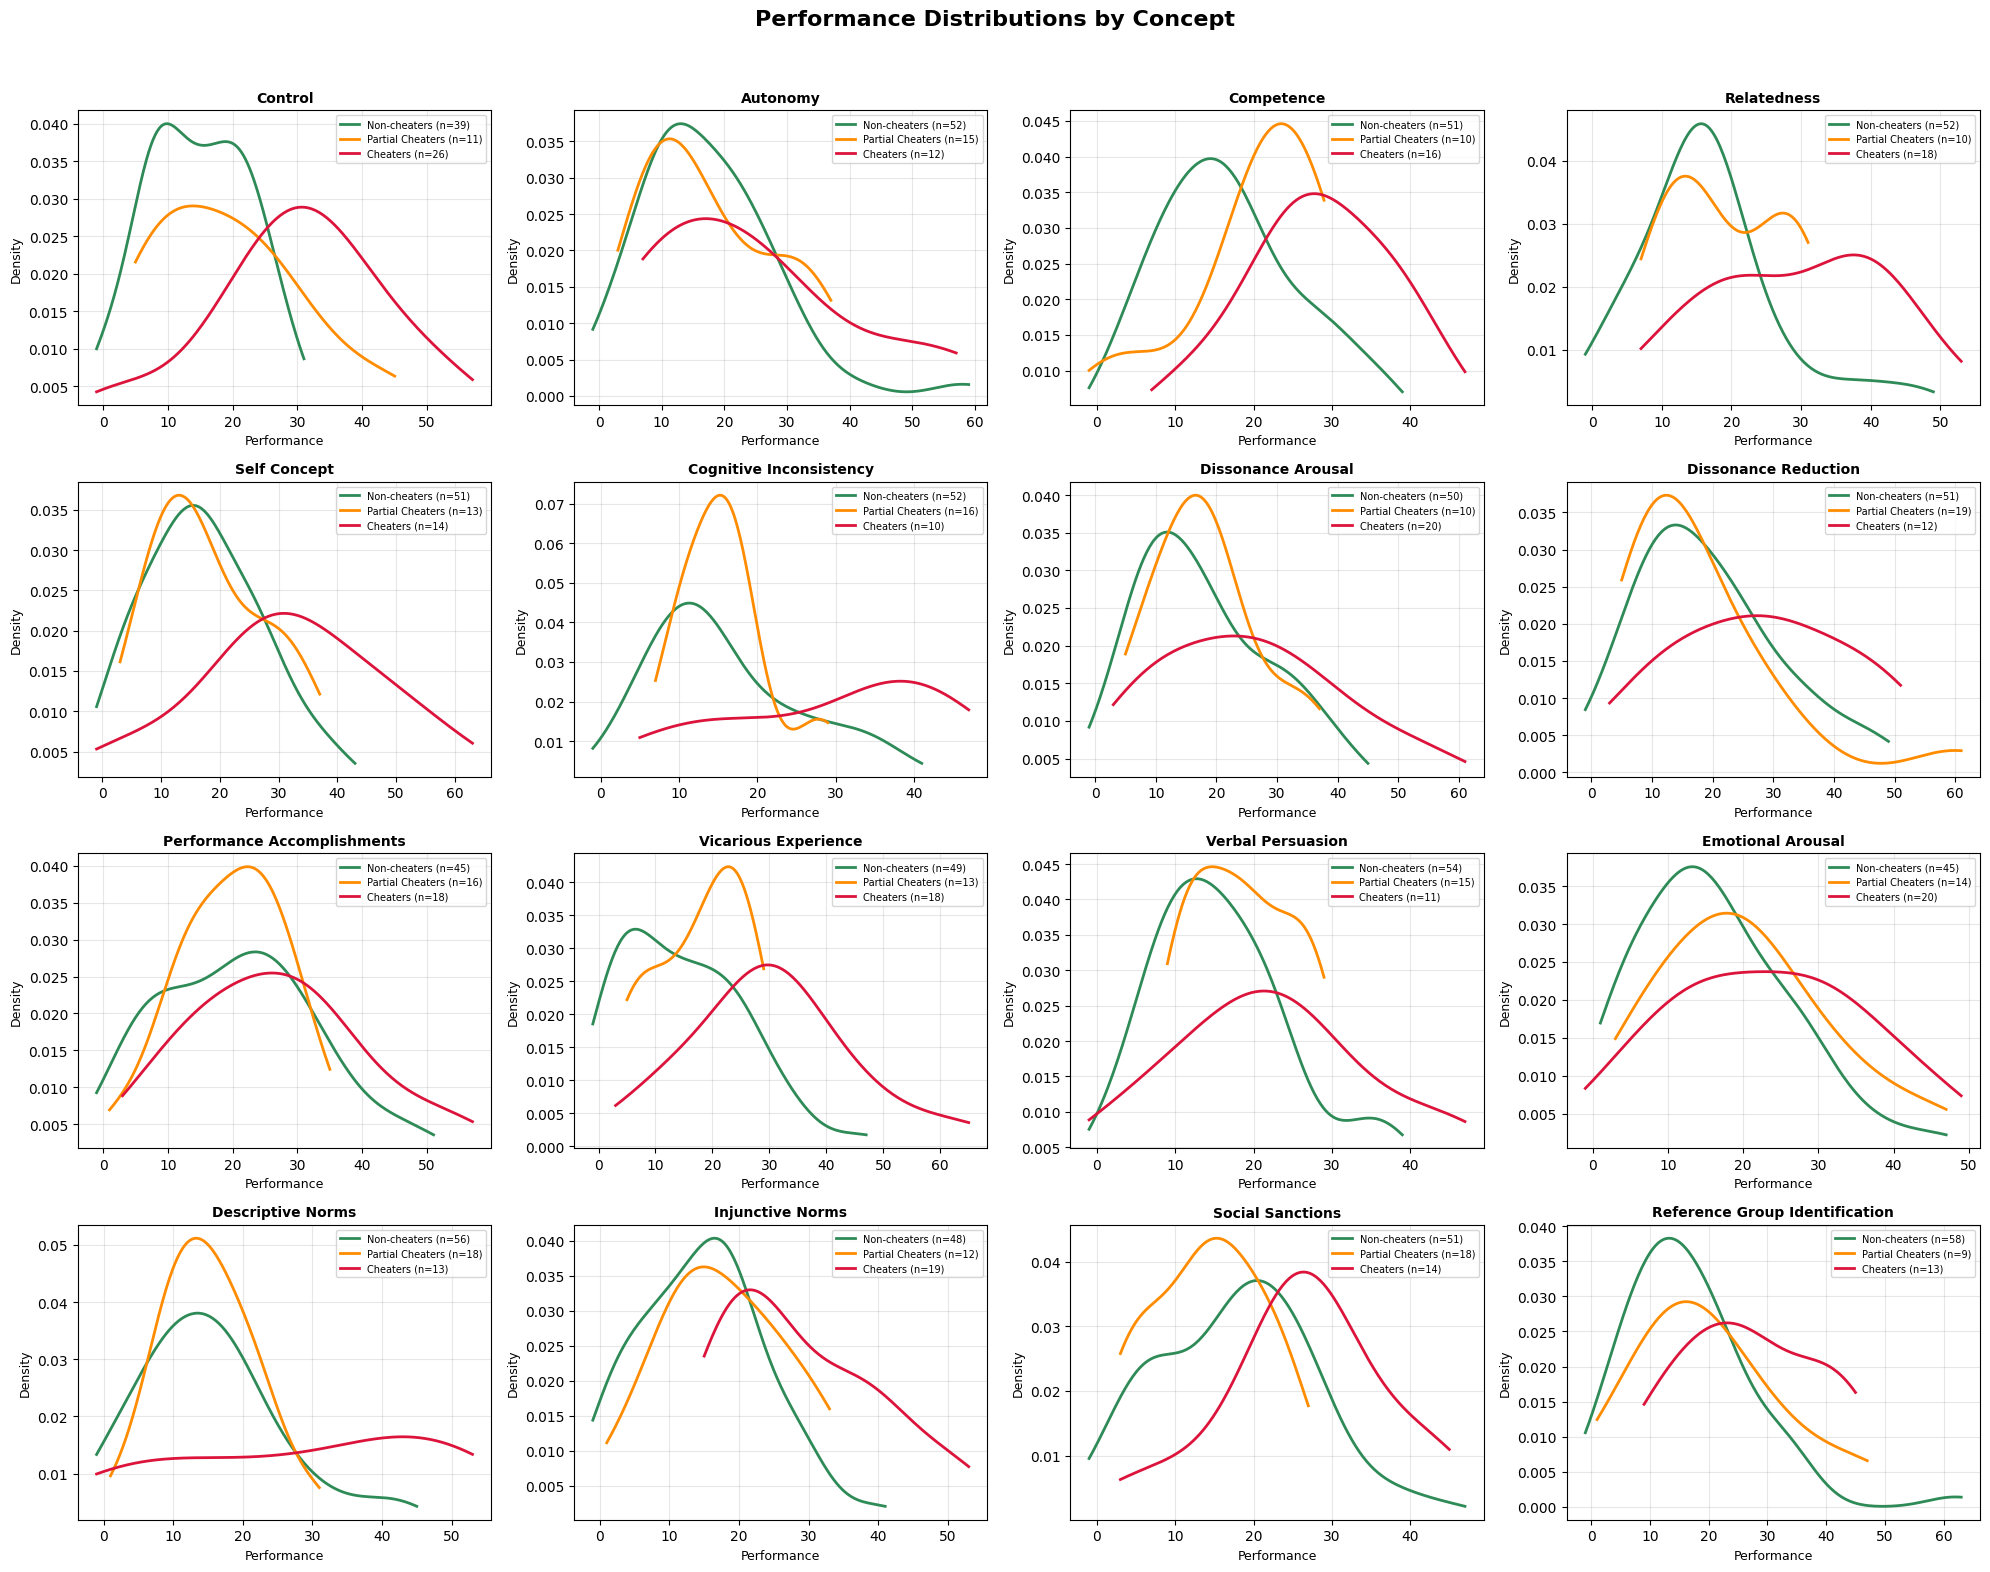

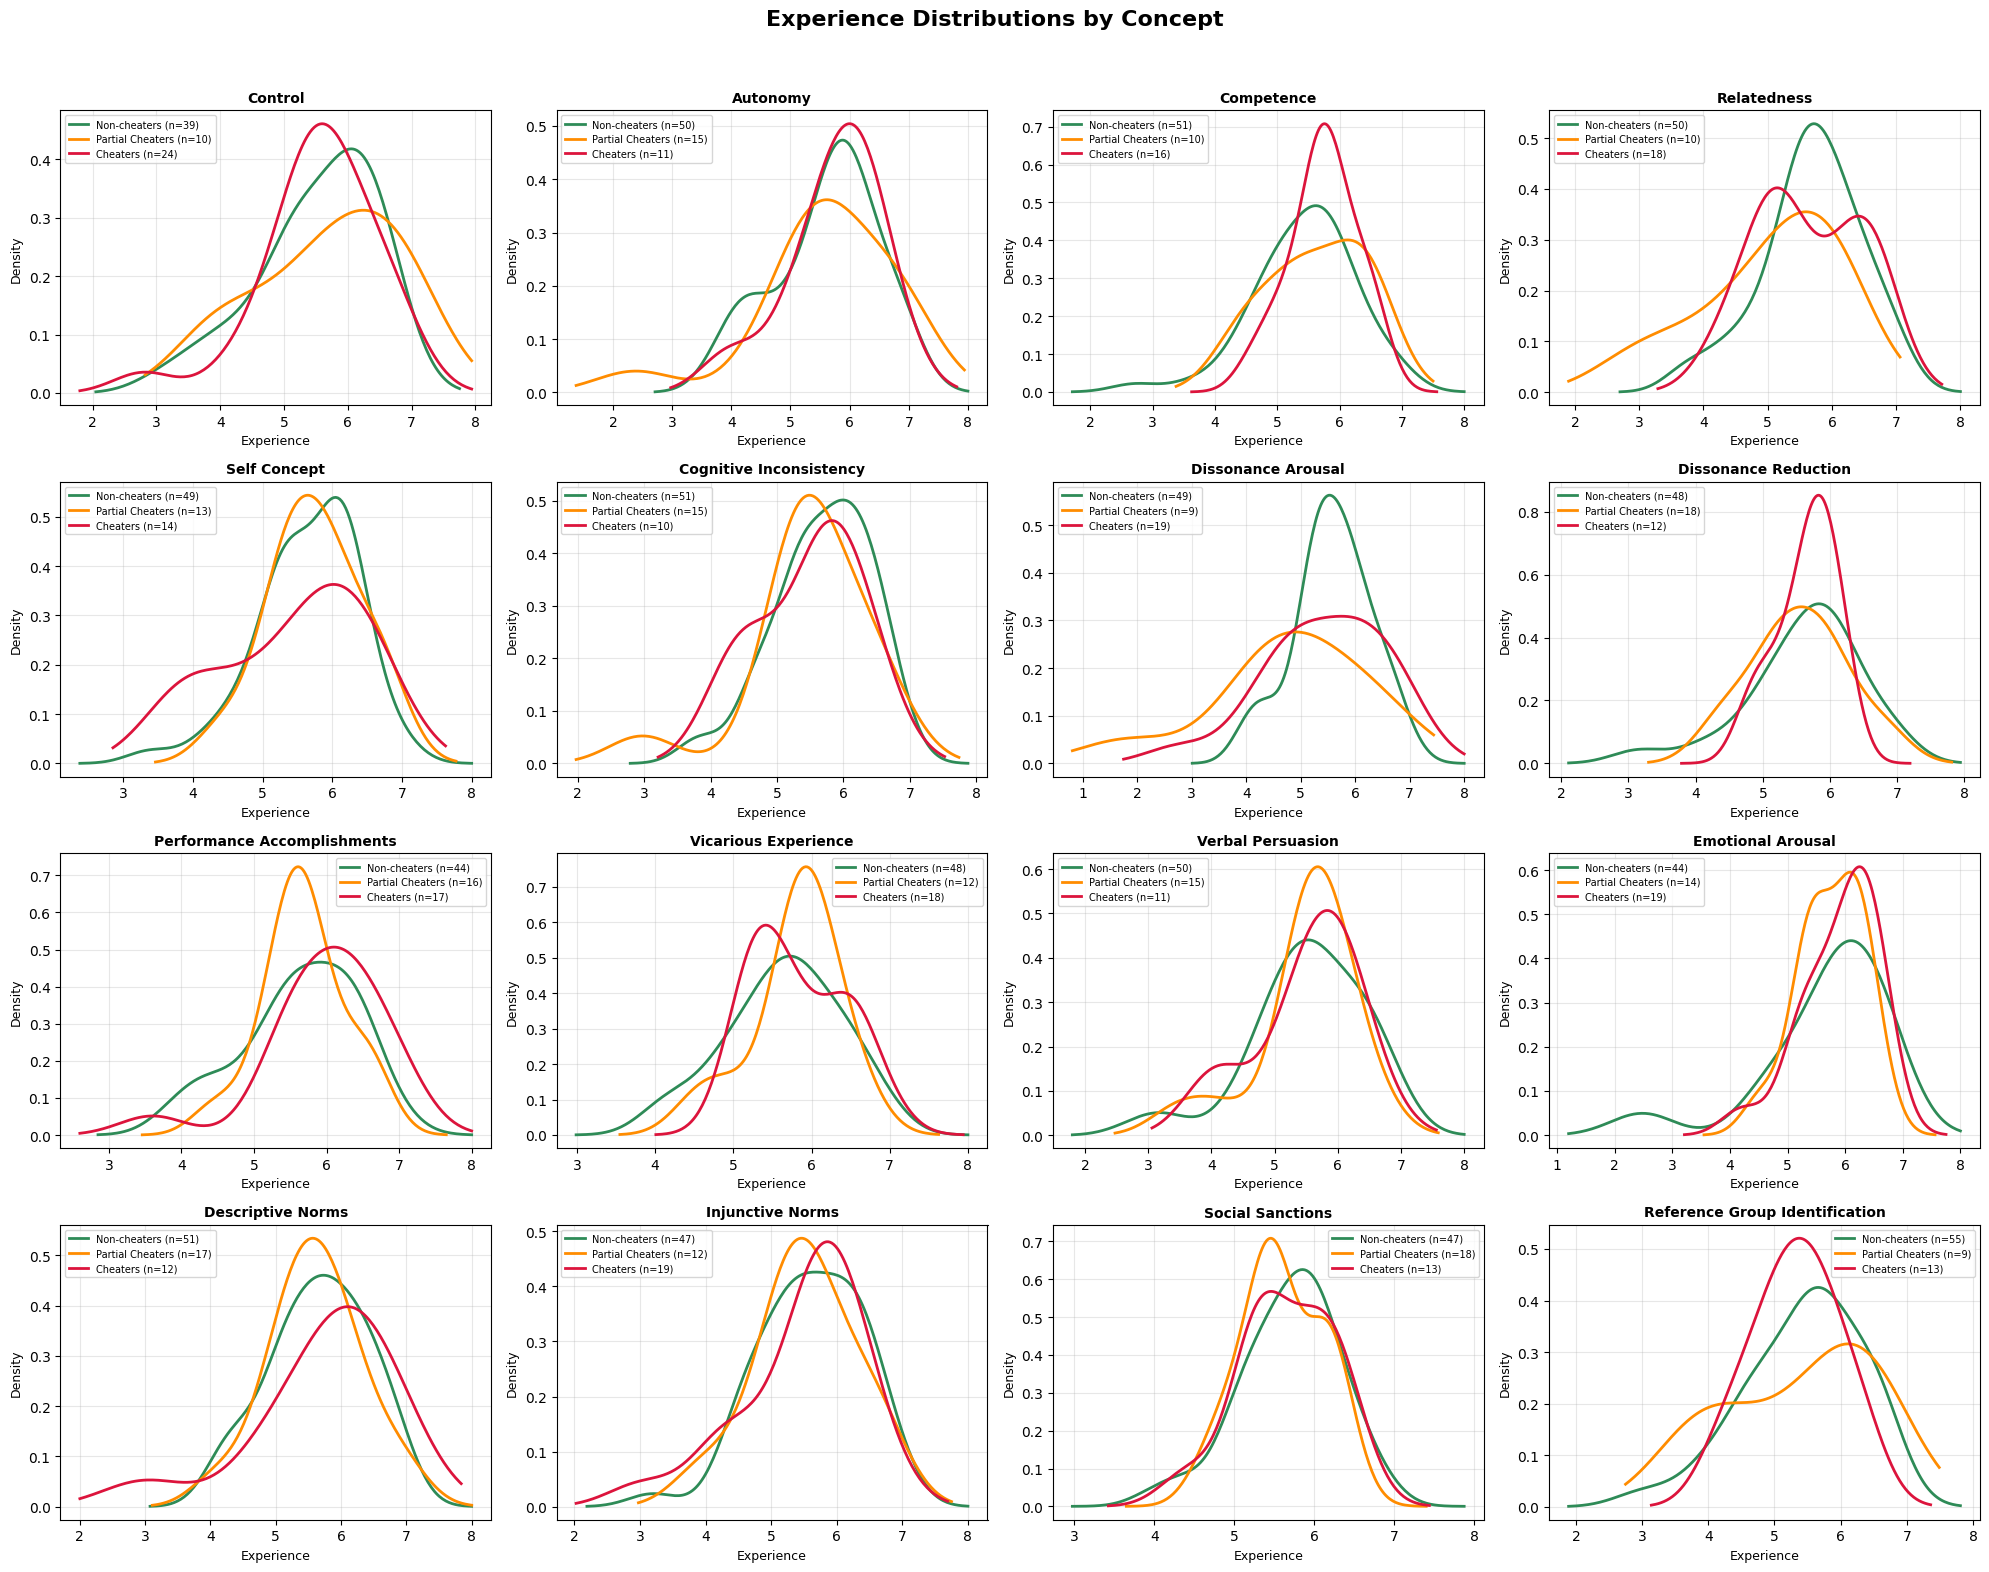

In [135]:
# =======================================================================================
# PLOTTING OF PERFORMANCE AND EXPERIENCE DISTRIBUTIONS PER CHEATING CATEGORY AND CONCEPT
# =======================================================================================

concept_order = ["control", "autonomy", "competence", "relatedness", "self_concept", 
                "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",
                "performance_accomplishments", "vicarious_experience", "verbal_persuasion", 
                "emotional_arousal", "descriptive_norms", "injunctive_norms", 
                "social_sanctions", "reference_group_identification"]

cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Cheaters'}
colors = ['#2E8B57', '#FF8C00', '#DC143C']

def plot_kde(ax, data, title, variable):
    for j, cheat_cat in enumerate([0, 1, 2]):
        subset = data[data['cheating_behavior'] == cheat_cat]
        values = subset[variable].dropna()
        if len(values) > 1:
            kde = stats.gaussian_kde(values)
            x_range = np.linspace(values.min() - 1, values.max() + 1, 200)
            ax.plot(x_range, kde(x_range), color=colors[j], linewidth=2,
                    label=f'{cheating_labels[cheat_cat]} (n={len(values)})')
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(variable.title(), fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

# --- Performance plots ---

fig_perf, axes_perf = plt.subplots(4, 4, figsize=(20, 16))
fig_perf.suptitle('Performance Distributions by Concept', fontsize=16, fontweight='bold')

for i, concept in enumerate(concept_order):
    row, col = divmod(i, 4)
    ax = axes_perf[row, col]
    concept_data = df[df['concept'] == concept]
    concept_title = concept.replace("_", " ").title()
    plot_kde(ax, concept_data, concept_title, 'performance')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Experience plots ---

fig_exp, axes_exp = plt.subplots(4, 4, figsize=(20, 16))
fig_exp.suptitle('Experience Distributions by Concept', fontsize=16, fontweight='bold')

for i, concept in enumerate(concept_order):
    row, col = divmod(i, 4)
    ax = axes_exp[row, col]
    concept_data = df[df['concept'] == concept]
    concept_title = concept.replace("_", " ").title()
    plot_kde(ax, concept_data, concept_title, 'experience')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [5]:
# -------------------------------
# DATA PREPARATION FOR MODELING
# -------------------------------

df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])

concept_ids = df['concept'].astype('category')

if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
interventions = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

y_cheat = df['cheating_behavior'].values
y_perf = df['performance'].values
y_exp = df['experience'].values

is_partialCheater, is_fullCheater = (y_cheat == 1).astype(int), (y_cheat == 2).astype(int)
perf_std, exp_std = np.std(y_perf), np.std(y_exp)

print(f"{len(df)} observations | {len(interventions)} intervention concepts")


df = df.dropna(subset=['word_creation_skill_level', 'moral_disengagement', 'cognitive_discomfort'])
df['ability_std'] = (df['word_creation_skill_level'] - df['word_creation_skill_level'].mean()) / df['word_creation_skill_level'].std()
df['moral_diseng_std'] = (df['moral_disengagement'] - df['moral_disengagement'].mean()) / df['moral_disengagement'].std()
df['stress_std'] = (df['cognitive_discomfort'] - df['cognitive_discomfort'].mean()) / df['cognitive_discomfort'].std()
ability_std = df['ability_std'].values
moral_diseng_std = df['moral_diseng_std'].values
stress_std = df['stress_std'].values


# ============================================================================
# CONTROL BASELINES CALCULATION
# ============================================================================

# Calculate control baselines from the full dataset
control_data = df[df['concept'] == 'control']
control_cheating = control_data['cheating_behavior'].mean()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()

# Convert control cheating to log-odds for ordered logistic
control_logit = np.log(control_cheating / (1 - control_cheating)) if control_cheating != 0 else -2

1232 observations | 15 intervention concepts


In [6]:

# ============================================================================
# MODEL SPECIFICATION
# ============================================================================

with pm.Model() as concept_model:

    # ----------------------------------------
    # MODEL 1: CHEATING BEHAVIOR (Ordered Logistic)
    #
    # log_odds(cheating) = β₀ 
    #                    + Σ(βᵢ×ConceptDummyᵢ)
    #                    + β_a×Ability
    #                    + β_m×MoralDisengagement
    #                    + β_s×Stress
    #                    + message_effects
    #
    # Where:
    # - β₀ = Control group cheating log-odds (baseline)
    # - βᵢ = Effect of each intervention concept vs control
    # - β_a = Effect of ability (standardized skill level)
    # - β_m = Effect of moral disengagement
    # - β_s = Effect of stress (cognitive discomfort)
    # - message_effects = deviation due to each motivational message
    # ----------------------------------------
    
    cutpoints = pm.Normal('cutpoints', mu=[-1.2, -0.2], sigma=1.0, shape=2, transform=pm.distributions.transforms.ordered)
    beta_cheat_intercept = pm.Normal('beta_cheat_intercept', mu=control_logit, sigma=0.5)  # control
    beta_cheat_concepts = pm.Normal('beta_cheat_concepts', mu=-1.29, sigma=0.79, shape=len(interventions))  # Literature effects
    msg_effect_cheat = pm.Normal('msg_effect_cheat', mu=0, sigma=pm.HalfNormal('sigma_msg_cheat', sigma=0.5), shape=len(message_ids.cat.categories))
    
    beta_cheat_ability = pm.Normal('beta_cheat_ability', mu=0, sigma=0.5)  # Ability effect on cheating
    beta_cheat_moral = pm.Normal('beta_cheat_moral', mu=1.0, sigma=0.5)   # Moral disengagement effect (expect positive)
    beta_cheat_stress = pm.Normal('beta_cheat_stress', mu=0.3, sigma=0.5)  # Stress effect (expect positive)

    eta_cheat = (beta_cheat_intercept + 
                 msg_effect_cheat[message_codes] + 
                 beta_cheat_ability * ability_std +
                 beta_cheat_moral * moral_diseng_std +
                 beta_cheat_stress * stress_std +
                 pm.math.switch(concept_codes > 0, beta_cheat_concepts[concept_codes - 1], 0))

    pm.OrderedLogistic('cheating_behavior', cutpoints=cutpoints, eta=eta_cheat, observed=y_cheat)

    # ----------------------------------------
    # MODEL 2: PERFORMANCE (Truncated Normal)
    #
    # Performance = β₀ 
    #             + Σ(βᵢ×ConceptDummyᵢ)
    #             + β_p×PartialCheater
    #             + β_f×FullCheater
    #             + Σ(βᵢₚ×ConceptDummyᵢ×PartialCheater)
    #             + Σ(βᵢf×ConceptDummyᵢ×FullCheater)
    #             + β_a×Ability
    #             + β_m×MoralDisengagement
    #             + β_s×Stress
    #             + message_effects
    #             + ε
    #
    # Where:
    # - β₀ = Control group performance mean (baseline)
    # - βᵢ = Effect of each intervention concept vs control
    # - β_p = Effect of partial cheating
    # - β_f = Effect of full cheating
    # - βᵢₚ = Concept × PartialCheater interaction
    # - βᵢf = Concept × FullCheater interaction
    # - β_a = Effect of ability (skill level)
    # - β_m = Effect of moral disengagement
    # - β_s = Effect of stress (cognitive discomfort)
    # - message_effects = deviation due to each motivational message
    # - ε = residual error
    # ----------------------------------------

    # ----------------------------------------
    # MODEL 3: EXPERIENCE (Truncated Normal)
    #
    # Experience = γ₀ 
    #            + Σ(γᵢ×ConceptDummyᵢ)
    #            + γ_p×PartialCheater
    #            + γ_f×FullCheater
    #            + Σ(γᵢₚ×ConceptDummyᵢ×PartialCheater)
    #            + Σ(γᵢf×ConceptDummyᵢ×FullCheater)
    #            + γ_a×Ability
    #            + γ_m×MoralDisengagement
    #            + γ_s×Stress
    #            + message_effects
    #            + ε
    #
    # Where:
    # - γ₀ = Control group experience mean (baseline)
    # - γᵢ = Effect of each intervention concept vs control
    # - γ_p = Effect of partial cheating
    # - γ_f = Effect of full cheating
    # - γᵢₚ = Concept × PartialCheater interaction
    # - γᵢf = Concept × FullCheater interaction
    # - γ_a = Effect of ability (skill level)
    # - γ_m = Effect of moral disengagement
    # - γ_s = Effect of stress (cognitive discomfort)
    # - message_effects = deviation due to each motivational message
    # - ε = residual error
    # ----------------------------------------
    
    for outcome, y, control_mu, std, name in zip(
        ['performance', 'experience'],
        [y_perf, y_exp],
        [control_performance, control_experience],
        [perf_std, exp_std],
        ['perf', 'exp']
    ):
        beta_intercept = pm.Normal(f'beta_{name}_intercept', mu=control_mu, sigma=2.0 if name == 'perf' else 0.5)
        if name == 'perf':
            beta_concepts = pm.Normal(f'beta_{name}_concepts', mu=-1.0, sigma=1.5, shape=len(interventions))
        else:  # for experience
            beta_concepts = pm.Normal(f'beta_{name}_concepts', mu=0, sigma=0.3, shape=len(interventions))
        beta_partial = pm.Normal(f'beta_{name}_partial', mu=0, sigma=std/2)
        beta_full = pm.Normal(f'beta_{name}_full', mu=0, sigma=std/2)
        beta_concept_partial = pm.Normal(f'beta_{name}_concept_partial', mu=0, sigma=std/4, shape=len(interventions))
        beta_concept_full = pm.Normal(f'beta_{name}_concept_full', mu=0, sigma=std/4, shape=len(interventions))
        msg_effect = pm.Normal(f'msg_effect_{name}', mu=0, sigma=pm.HalfNormal(f'sigma_msg_{name}', sigma=std/4), shape=len(message_ids.cat.categories))

        if name == 'perf':
            # For performance: expect positive ability effect, negative stress effect
            beta_ability = pm.Normal(f'beta_{name}_ability', mu=2.0, sigma=1.0)  # Higher ability → better performance
            beta_moral = pm.Normal(f'beta_{name}_moral', mu=0, sigma=0.8)        # Unclear direction
            beta_stress = pm.Normal(f'beta_{name}_stress', mu=-1.0, sigma=0.8)   # Higher stress → worse performance
        else:  # experience
            # For experience: expect positive ability effect, negative stress effect
            beta_ability = pm.Normal(f'beta_{name}_ability', mu=0.1, sigma=0.3)  # Higher ability → better experience
            beta_moral = pm.Normal(f'beta_{name}_moral', mu=0, sigma=0.3)        # Unclear direction
            beta_stress = pm.Normal(f'beta_{name}_stress', mu=-0.2, sigma=0.3)   # Higher stress → worse experience
            
            
        mu = (beta_intercept +
              beta_partial * is_partialCheater +
              beta_full * is_fullCheater +
              msg_effect[message_codes] +
              beta_ability * ability_std +
              beta_moral * moral_diseng_std +
              beta_stress * stress_std +
              pm.math.switch(concept_codes > 0,
                  beta_concepts[concept_codes - 1] +
                  beta_concept_partial[concept_codes - 1] * is_partialCheater +
                  beta_concept_full[concept_codes - 1] * is_fullCheater,
                  0))

        pm.TruncatedNormal(outcome, mu=mu, sigma=pm.HalfNormal(f'sigma_{name}', sigma=std),
                           lower=max(0, y.min() - 2*std) if name == 'perf' else max(1, y.min() - 2*std),
                           upper=y.max() + 2*std if name == 'perf' else min(7, y.max() + 2*std),
                           observed=y)

print("Model specification complete!")

Model specification complete!


In [7]:
# ============================================================================
# MODEL FITTING
# ============================================================================

print("Fitting model...")
with concept_model:
    trace = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

print("Model fitted successfully!")

Fitting model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, beta_cheat_intercept, beta_cheat_concepts, sigma_msg_cheat, msg_effect_cheat, beta_cheat_ability, beta_cheat_moral, beta_cheat_stress, beta_perf_intercept, beta_perf_concepts, beta_perf_partial, beta_perf_full, beta_perf_concept_partial, beta_perf_concept_full, sigma_msg_perf, msg_effect_perf, beta_perf_ability, beta_perf_moral, beta_perf_stress, sigma_perf, beta_exp_intercept, beta_exp_concepts, beta_exp_partial, beta_exp_full, beta_exp_concept_partial, beta_exp_concept_full, sigma_msg_exp, msg_effect_exp, beta_exp_ability, beta_exp_moral, beta_exp_stress, sigma_exp]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 371 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model fitted successfully!


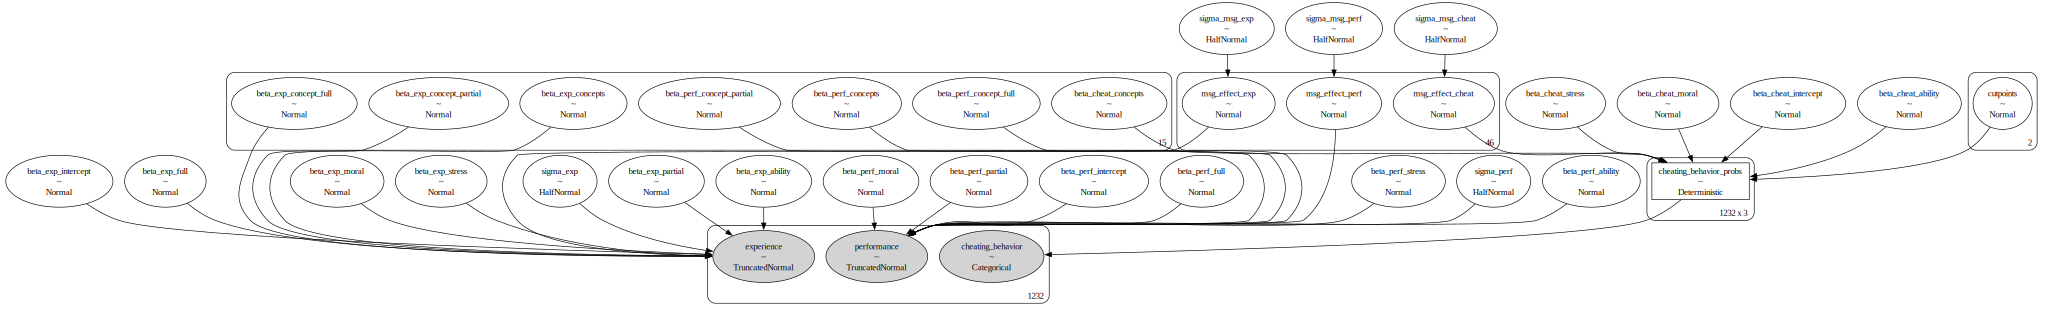

In [8]:
pm.model_to_graphviz(concept_model)

Sampling: [cheating_behavior, experience, performance]


Output()

array([<Axes: xlabel='cheating_behavior'>, <Axes: xlabel='performance'>,
       <Axes: xlabel='experience'>], dtype=object)

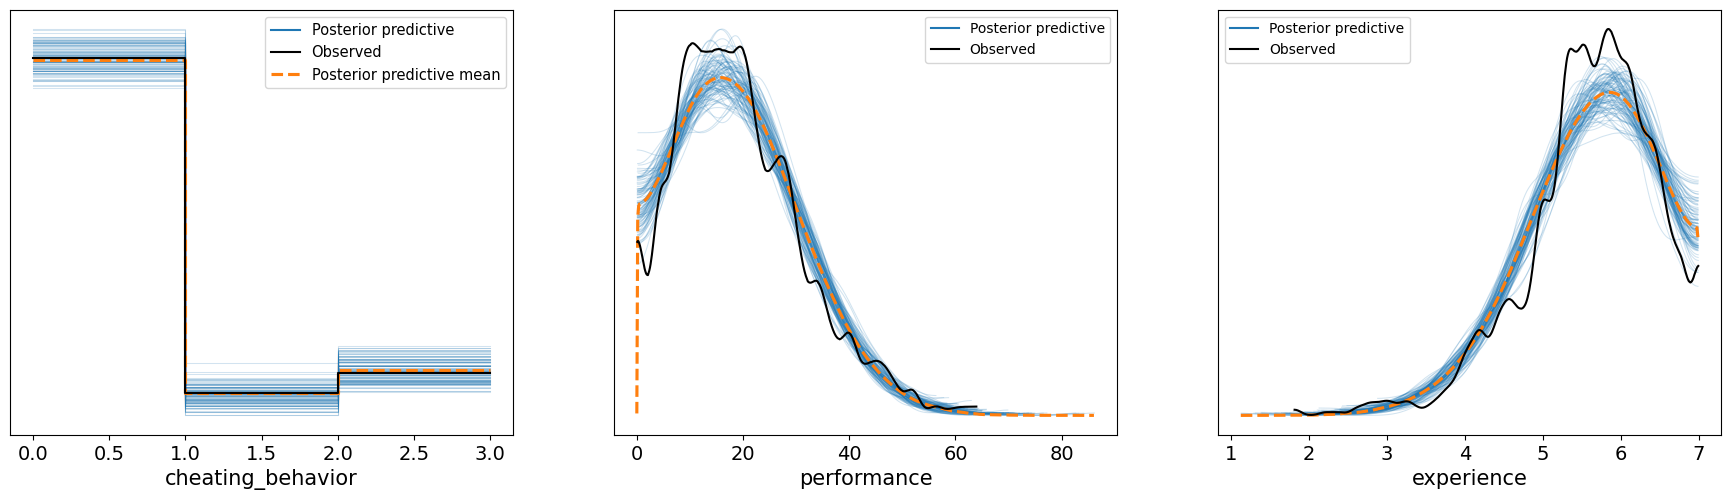

In [9]:
# ============================================================================
# ROBUST MODEL CHECKING
# ============================================================================

# Posterior predictive checks
with concept_model:
    ppc = pm.sample_posterior_predictive(trace)
    
# Check if model captures data patterns
az.plot_ppc(ppc, num_pp_samples=100)

In [10]:
# ============================================================================
# POSTERIOR COEFFICIENTS WITH STANDARDIZED EFFECT SIZES (Cohen's d)
# ============================================================================

# Extract posterior summaries with HDI
summary = az.summary(trace, hdi_prob=0.95, round_to=3)

concept_names = interventions

# Calculate pooled SDs for performance and experience
perf_sd = df['performance'].std()
exp_sd = df['experience'].std()

def display_effects(var_name, outcome, sd=None, is_logodds=False):
    print(f"\n{outcome}")
    print("=" * 120)
    print(f"{'Theory':20} {'Concept':25} {'Main Effect with 95% HDI':>25} {'Standardized Effect with 95% HDI':>25} {'P(any change)':>12}")
    print("-" * 120)
    
    posterior_samples = trace.posterior[var_name].values  # Shape: (chains, draws, concepts)
    
    # Calculate overall intervention effect (mean across all concepts)
    overall_samples = np.mean(posterior_samples, axis=2).flatten()  # Average across concepts
    overall_mean = np.mean(overall_samples)
    overall_hdi = np.percentile(overall_samples, [2.5, 97.5])
    
    # Calculate overall standardized effect and probability
    if is_logodds:
        overall_d_samples = overall_samples * np.sqrt(3) / np.pi
        overall_prob = np.mean(overall_samples < 0)  # P(reduction for cheating)
    else:
        overall_d_samples = overall_samples / sd if sd else np.full_like(overall_samples, np.nan)
        overall_prob = np.mean(overall_samples > 0)  # P(improvement)
    
    overall_d_mean = np.mean(overall_d_samples)
    overall_d_hdi = np.percentile(overall_d_samples, [2.5, 97.5])
    
    # Print overall intervention effect row
    print(f"{'OVERALL':20} {'Intervention Effect':25} {overall_mean:12.3f} [{overall_hdi[0]:6.3f}, {overall_hdi[1]:6.3f}]"
          f" {overall_d_mean:12.3f} [{overall_d_hdi[0]:6.3f}, {overall_d_hdi[1]:6.3f}]"
          f" {overall_prob:12.3f}")
    print("-" * 120)
    
    # Theory mapping
    theory_map = {
        "autonomy": "Self-Determination",
        "competence": "Self-Determination",
        "relatedness": "Self-Determination",
        "self_concept": "Cognitive Dissonance",
        "cognitive_inconsistency": "Cognitive Dissonance",
        "dissonance_arousal": "Cognitive Dissonance",
        "dissonance_reduction": "Cognitive Dissonance",
        "performance_accomplishments": "Self-Efficacy",
        "vicarious_experience": "Self-Efficacy",
        "verbal_persuasion": "Self-Efficacy",
        "emotional_arousal": "Self-Efficacy",
        "descriptive_norms": "Social Norms",
        "injunctive_norms": "Social Norms",
        "social_sanctions": "Social Norms",
        "reference_group_identification": "Social Norms"
    }
    
    last_theory = None
    
    for concept in theory_map:
        i = concept_names.index(concept)
        theory = theory_map[concept]
        
        param_name = f"{var_name}[{i}]"
        if param_name not in summary.index:
            print(f"Warning: {param_name} not found in summary")
            continue
        
        mean = summary.loc[param_name, 'mean']
        hdi = summary.loc[param_name, ['hdi_2.5%', 'hdi_97.5%']].values
        
        concept_samples = posterior_samples[:, :, i].flatten()
        
        # Calculate probability of any change
        if is_logodds:
            # For cheating (log-odds), we want probability of reduction (negative effect)
            prob_change = np.mean(concept_samples < 0)
            d_samples = concept_samples * np.sqrt(3) / np.pi
        else:
            # For performance and experience, we want probability of improvement (positive effect)
            prob_change = np.mean(concept_samples > 0)
            d_samples = concept_samples / sd if sd else np.full_like(concept_samples, np.nan)
        
        d_mean = np.mean(d_samples)
        d_hdi = np.percentile(d_samples, [2.5, 97.5])
        
        # Print theory header only when it changes
        theory_str = theory if theory != last_theory else ""
        last_theory = theory
        
        print(f"{theory_str:20} {concept:25} {mean:12.3f} [{hdi[0]:6.3f}, {hdi[1]:6.3f}]"
              f" {d_mean:12.3f} [{d_hdi[0]:6.3f}, {d_hdi[1]:6.3f}]"
              f" {prob_change:12.3f}")
    
    print("-" * 120)

# Display
print("="*100)
print("POSTERIOR COEFFICIENTS AND STANDARDIZED EFFECT SIZES (Cohen's d)")
print("="*100)

display_effects("beta_cheat_concepts", "1. CHEATING BEHAVIOR", is_logodds=True)
display_effects("beta_perf_concepts", "2. PERFORMANCE", sd=perf_sd)
display_effects("beta_exp_concepts", "3. EXPERIENCE", sd=exp_sd)

print("="*100)

POSTERIOR COEFFICIENTS AND STANDARDIZED EFFECT SIZES (Cohen's d)

1. CHEATING BEHAVIOR
Theory               Concept                    Main Effect with 95% HDI Standardized Effect with 95% HDI P(any change)
------------------------------------------------------------------------------------------------------------------------
OVERALL              Intervention Effect             -1.099 [-1.437, -0.765]       -0.606 [-0.792, -0.422]        1.000
------------------------------------------------------------------------------------------------------------------------
Self-Determination   autonomy                        -1.243 [-1.835, -0.687]       -0.685 [-1.011, -0.369]        1.000
                     competence                      -1.158 [-1.741, -0.600]       -0.639 [-0.960, -0.331]        1.000
                     relatedness                     -1.068 [-1.678, -0.521]       -0.589 [-0.927, -0.289]        1.000
Cognitive Dissonance self_concept                    -1.125 [-1.677, -0

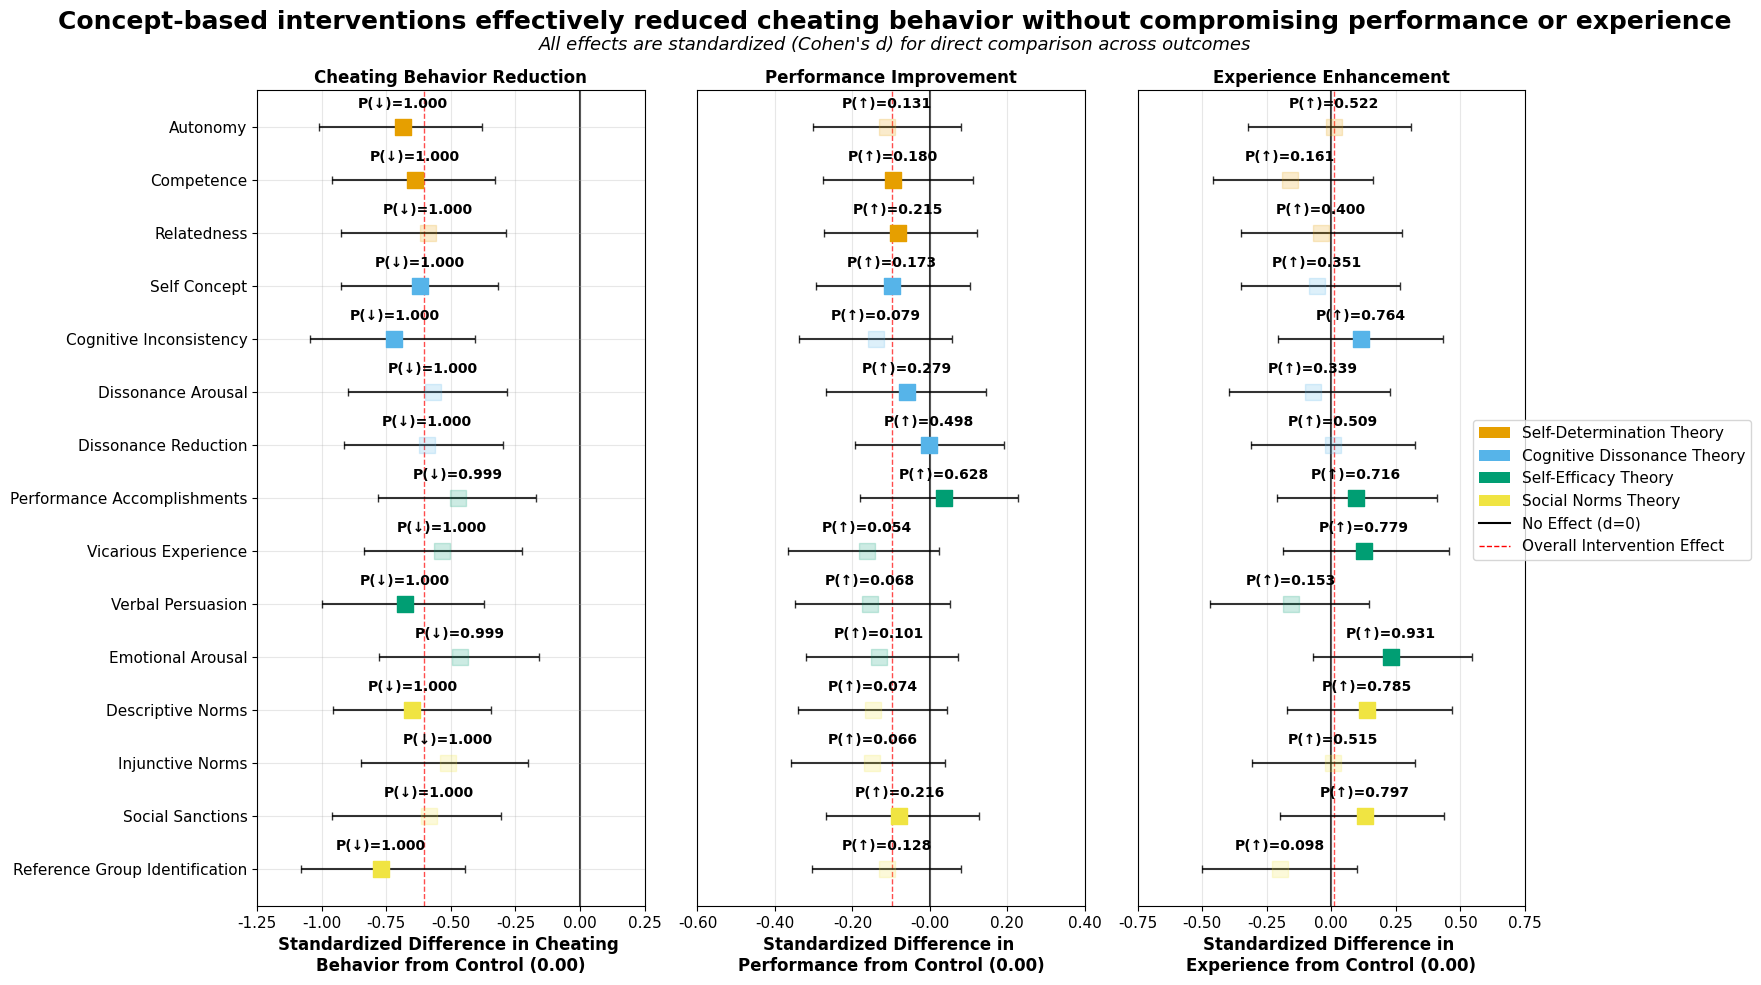

In [11]:
# ============================================================================
# RQ1: Visualization of concepts effects on cheating, performance, and experience
# ============================================================================

from matplotlib.patches import Patch

# Theory colors and grouping
theory_colors = {
    "autonomy": "#E69F00", "competence": "#E69F00", "relatedness": "#E69F00",
    "self_concept": "#56B4E9", "cognitive_inconsistency": "#56B4E9", 
    "dissonance_arousal": "#56B4E9", "dissonance_reduction": "#56B4E9",
    "performance_accomplishments": "#009E73", "vicarious_experience": "#009E73", 
    "verbal_persuasion": "#009E73", "emotional_arousal": "#009E73",
    "descriptive_norms": "#F0E442", "injunctive_norms": "#F0E442", 
    "social_sanctions": "#F0E442", "reference_group_identification": "#F0E442"
}

theory_order = [
    "autonomy", "competence", "relatedness",  # Self-Determination
    "self_concept", "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",  # Cognitive Dissonance
    "performance_accomplishments", "vicarious_experience", "verbal_persuasion", "emotional_arousal",  # Self-Efficacy
    "descriptive_norms", "injunctive_norms", "social_sanctions", "reference_group_identification"  # Social Norms
]


# Reuse posterior samples
beta_cheat = trace.posterior['beta_cheat_concepts'].values.reshape(-1, len(concept_names))
beta_perf = trace.posterior['beta_perf_concepts'].values.reshape(-1, len(concept_names))
beta_exp = trace.posterior['beta_exp_concepts'].values.reshape(-1, len(concept_names))

# Calculate Cohen's d effect sizes
concept_results = {}
for i, name in enumerate(concept_names):
    cheat_d = beta_cheat[:, i] * np.sqrt(3) / np.pi
    perf_d = beta_perf[:, i] / perf_sd
    exp_d = beta_exp[:, i] / exp_sd
    concept_results[name] = {
        'cheat_d': cheat_d.mean(),
        'cheat_d_hdi': az.hdi(cheat_d, hdi_prob=0.95),
        'cheat_prob_decrease': (beta_cheat[:, i] < 0).mean(),
        'perf_d': perf_d.mean(),
        'perf_d_hdi': az.hdi(perf_d, hdi_prob=0.95),
        'perf_prob_increase': (beta_perf[:, i] > 0).mean(),
        'exp_d': exp_d.mean(),
        'exp_d_hdi': az.hdi(exp_d, hdi_prob=0.95),
        'exp_prob_increase': (beta_exp[:, i] > 0).mean(),
        'color': theory_colors.get(name, '#999999')
    }

# Order results by theory grouping
results = []
for concept in reversed(theory_order):
    if concept in concept_results:
        r = concept_results[concept].copy()
        r['label'] = concept.replace('_', ' ').title()
        results.append(r)

# Overall effects
overall_cheat_d = np.mean([beta_cheat[:, i] * np.sqrt(3) / np.pi for i in range(len(concept_names))], axis=0).mean()
overall_perf_d = np.mean([beta_perf[:, i] / perf_sd for i in range(len(concept_names))], axis=0).mean()
overall_exp_d = np.mean([beta_exp[:, i] / exp_sd for i in range(len(concept_names))], axis=0).mean()

def calculate_smart_xlim(results, effect_key, hdi_key, baseline=0.0, padding_factor=0.15):
    all_values = []
    for r in results:
        all_values += [r[effect_key], *r[hdi_key]]
    all_values.append(baseline)
    data_min, data_max = min(all_values), max(all_values)
    padding = max((data_max - data_min) * padding_factor, 0.05)
    xmin, xmax = data_min - padding, data_max + padding
    if abs(xmin - baseline) < padding * 0.5: xmin = baseline - padding
    if abs(xmax - baseline) < padding * 0.5: xmax = baseline + padding
    return xmin, xmax

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
y_pos = range(len(results))
plot_specs = [
    (ax1, 'cheat_d', 'cheat_d_hdi', 'cheat_prob_decrease', 'Cheating Behavior Reduction', "Standardized Difference in Cheating \nBehavior from Control (0.00)", overall_cheat_d, 0.0, True),
    (ax2, 'perf_d', 'perf_d_hdi', 'perf_prob_increase', 'Performance Improvement', "Standardized Difference in \nPerformance from Control (0.00)", overall_perf_d, 0.0, False),
    (ax3, 'exp_d', 'exp_d_hdi', 'exp_prob_increase', 'Experience Enhancement', "Standardized Difference in \nExperience from Control (0.00)", overall_exp_d, 0.0, False)
]

for ax, e_key, h_key, p_key, title, subtitle, o_mean, base, is_neg in plot_specs:
    xlim = calculate_smart_xlim(results, e_key, h_key, base)
    for j, r in enumerate(results):
        effect, hdi, prob, color = r[e_key], r[h_key], r[p_key], r['color']
        alpha = 0.2 if (is_neg and effect > o_mean) or (not is_neg and effect < o_mean) else 1.0
        ax.scatter(effect, j, color=color, marker='s', s=120, alpha=alpha, zorder=3)
        ax.errorbar(effect, j, xerr=[[effect - hdi[0]], [hdi[1] - effect]], fmt='none', color='black', capsize=3, alpha=0.8, zorder=2)
        ax.text(effect, j + 0.3, f"P({'↓' if is_neg else '↑'})={prob:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.axvline(base, color='black', linestyle='-', alpha=0.8, linewidth=1.5, label='No Effect (d=0)', zorder=1)
    ax.axvline(o_mean, color='red', linestyle='--', alpha=0.7, linewidth=1, label='Overall Intervention Effect', zorder=1)
    ax.set_xlim(xlim)
    
    tick_step = 0.1 if xlim[1] - xlim[0] <= 0.5 else (0.2 if xlim[1] - xlim[0] <= 1.0 else 0.25)
    tick_start = np.floor(xlim[0] / tick_step) * tick_step
    tick_end = np.ceil(xlim[1] / tick_step) * tick_step
    ticks = np.arange(tick_start, tick_end + tick_step/2, tick_step)
    if 0 not in ticks and xlim[0] <= 0 <= xlim[1] and min(abs(ticks - 0)) > tick_step * 0.5:
        ticks = np.append(ticks, 0)
    ticks = np.sort(ticks)
    clean_ticks = [ticks[0]]
    for t in ticks[1:]:
        if t - clean_ticks[-1] >= tick_step * 0.8:
            clean_ticks.append(t)
    ax.set_xticks(clean_ticks)
    ax.set_xticklabels([f'{t:.2f}' for t in clean_ticks])
    
    ax.set_xlabel(subtitle, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=5)
    ax.grid(True, alpha=0.3)
    if ax == ax1:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([r['label'] for r in results], fontsize=11)
    else:
        ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

# Legend
theory_labels = [("Self-Determination Theory", "#E69F00"), ("Cognitive Dissonance Theory", "#56B4E9"),
                 ("Self-Efficacy Theory", "#009E73"), ("Social Norms Theory", "#F0E442")]
legend_elements = [Patch(facecolor=c, label=l) for l, c in theory_labels]
legend_elements += [plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='No Effect (d=0)'),
                    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='Overall Intervention Effect')]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=11)

plt.suptitle("Concept-based interventions effectively reduced cheating behavior without compromising performance or experience", fontsize=18, fontweight='bold', y=0.98)
plt.figtext(0.5, 0.94, 'All effects are standardized (Cohen\'s d) for direct comparison across outcomes', ha='center', fontsize=13, style='italic')
plt.tight_layout(rect=[0, 0, 0.85, 0.93])
plt.subplots_adjust(top=0.90, right=0.85)
plt.show()


In [12]:
# ============================================================================
# RQ2: Do Concepts Influence Relationships Between Outcomes?
# ============================================================================

# Extract posterior samples from your existing trace
beta_cheat = trace.posterior['beta_cheat_concepts'].values.reshape(-1, len(concept_names))
beta_perf = trace.posterior['beta_perf_concepts'].values.reshape(-1, len(concept_names))
beta_exp = trace.posterior['beta_exp_concepts'].values.reshape(-1, len(concept_names))

# Calculate covariance matrix for each posterior sample
covariances_by_concept = {}

for i, concept in enumerate(concept_names):
    # Stack the posterior samples for this concept
    outcomes = np.column_stack([
        beta_cheat[:, i],  # cheating effects
        beta_perf[:, i],   # performance effects  
        beta_exp[:, i]     # experience effects
    ])
    
    # Calculate covariance matrix
    cov_matrix = np.cov(outcomes.T)
    covariances_by_concept[concept] = cov_matrix

# For control (baseline)
control_outcomes = np.column_stack([
    np.zeros(len(beta_cheat)),  # no effect for control
    np.zeros(len(beta_perf)),
    np.zeros(len(beta_exp))
])
covariances_by_concept['control'] = np.cov(control_outcomes.T)


def analyze_covariance_results(covariances_by_concept):
   results = []
   
   outcome_names = ['Cheating', 'Performance', 'Experience']
   
   for concept, cov_matrix in covariances_by_concept.items():
       if concept == 'control':
           continue  # Skip control (all zeros)
           
       results.append({
           'Concept': concept.replace('_', ' ').title(),
           'Cheat-Perf Covariance': cov_matrix[0, 1],
           'Cheat-Exp Covariance': cov_matrix[0, 2], 
           'Perf-Exp Covariance': cov_matrix[1, 2],
           'Cheating Variance': cov_matrix[0, 0],
           'Performance Variance': cov_matrix[1, 1],
           'Experience Variance': cov_matrix[2, 2]
       })
   
   df_results = pd.DataFrame(results)
   
   # Sort by strongest cheat-performance relationship
   df_results = df_results.reindex(df_results['Cheat-Perf Covariance'].abs().sort_values(ascending=False).index)
   
   print("="*120)
   print("COVARIANCE ANALYSIS: HOW CONCEPTS INFLUENCE OUTCOME RELATIONSHIPS")
   print("="*120)
   print(df_results.round(4).to_string(index=False))
   
   # RQ2 Analysis
   print("\n" + "="*80)
   print("RQ2: DO CONCEPTS INFLUENCE RELATIONSHIPS BETWEEN OUTCOMES?")
   print("="*80)
   
   # Analyze covariance strengths
   cheat_perf_covs = df_results['Cheat-Perf Covariance'].values
   cheat_exp_covs = df_results['Cheat-Exp Covariance'].values
   perf_exp_covs = df_results['Perf-Exp Covariance'].values
   
   # Define thresholds for strength (based on your data scale)
   weak_threshold = 0.005
   moderate_threshold = 0.015
   
   def classify_strength(cov_value):
       abs_cov = abs(cov_value)
       if abs_cov < weak_threshold:
           return "Weak"
       elif abs_cov < moderate_threshold:
           return "Moderate" 
       else:
           return "Strong"
   
   # Count relationships
   positive_cheat_perf = sum(cheat_perf_covs > 0)
   negative_cheat_perf = sum(cheat_perf_covs < 0)
   
   print(f"CHEATING-PERFORMANCE RELATIONSHIP:")
   print(f"  • Concepts with POSITIVE covariance: {positive_cheat_perf}/{len(df_results)} ({positive_cheat_perf/len(df_results)*100:.1f}%)")
   print(f"  • Concepts with NEGATIVE covariance: {negative_cheat_perf}/{len(df_results)} ({negative_cheat_perf/len(df_results)*100:.1f}%)")
   print(f"  • Mean covariance: {cheat_perf_covs.mean():.4f}")
   print(f"  • Strongest positive: {cheat_perf_covs.max():.4f} ({classify_strength(cheat_perf_covs.max())})")
   if negative_cheat_perf > 0:
       print(f"  • Strongest negative: {cheat_perf_covs.min():.4f} ({classify_strength(cheat_perf_covs.min())})")
   
   # Overall conclusion
   print(f"\nOVERALL CONCLUSION FOR RQ2:")
   print("-" * 40)
   
   if positive_cheat_perf > negative_cheat_perf:
       dominant_direction = "POSITIVE (aligned effects)"
       evidence_strength = classify_strength(cheat_perf_covs.mean())
   else:
       dominant_direction = "NEGATIVE (trade-off effects)" 
       evidence_strength = classify_strength(abs(cheat_perf_covs.mean()))
   
   print(f"✓ YES, concepts DO influence outcome relationships")
   print(f"✓ Dominant pattern: {dominant_direction}")
   print(f"✓ Relationship strength: {evidence_strength.upper()}")
   
   if positive_cheat_perf >= len(df_results) * 0.8:  # 80% or more positive
       print(f"✓ STRONG EVIDENCE: {positive_cheat_perf}/{len(df_results)} concepts create synergistic effects")
       print(f"✓ This SUPPORTS your 'no trade-off' hypothesis!")
   elif negative_cheat_perf >= len(df_results) * 0.8:  # 80% or more negative  
       print(f"⚠ CAUTION: {negative_cheat_perf}/{len(df_results)} concepts show trade-off patterns")
   else:
       print(f"→ MIXED EVIDENCE: Concepts vary in their relationship effects")
   
   return df_results

# Run the analysis
results_df = analyze_covariance_results(covariances_by_concept)

COVARIANCE ANALYSIS: HOW CONCEPTS INFLUENCE OUTCOME RELATIONSHIPS
                       Concept  Cheat-Perf Covariance  Cheat-Exp Covariance  Perf-Exp Covariance  Cheating Variance  Performance Variance  Experience Variance
   Performance Accomplishments                -0.0132               -0.0006               0.0021             0.0781                1.4247               0.0177
             Emotional Arousal                 0.0107               -0.0009               0.0004             0.0840                1.4488               0.0166
                    Competence                -0.0099               -0.0004               0.0009             0.0866                1.4296               0.0166
             Verbal Persuasion                -0.0076                0.0005              -0.0002             0.0813                1.4455               0.0160
       Cognitive Inconsistency                -0.0072               -0.0005               0.0001             0.0888                1.3820  